# Forecaster with Deep Learning

## Recurrent Neural Networks (RNN) and Long Short-Term Memory (LSTM)

Recurrent Neural Networks (RNN) are a type of neural networks designed to process data that follows a sequential order. In conventional neural networks, such as feedforward networks, information flows in one direction, from input to output through hidden layers, without considering the sequential structure of the data. In contrast, RNNs maintain internal states or memories, which allow them to remember past information and use it to predict future data in the sequence.

The basic unit of an RNN is the recurrent cell. This cell takes two inputs: the current input and the previous hidden state. The hidden state can be understood as a "memory" that retains information from previous iterations. The current input and the previous hidden state are combined to calculate the current output and the new hidden state. This output is used as input for the next iteration, along with the next input in the data sequence.

Despite the advances that have been achieved with RNN architectures, they have limitations to capture long-term patterns. This is why variants such as  Long Short-Term Memory (LSTM) and Gated Recurrent Units (GRU) have been developed, which address these problems and allow long-term information to be retained more effectively.

<p align="center"><img src='../img/schema-rnn-model.jpg'style="width: 600px"></p>


<center><font size='2.5'> <i>RNN diagram. Fuente: James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). An introduction to statistical learning (1st ed.) [PDF]. Springer.</i></font></center>


Long Short-Term Memory (LSTM) neural networks are a specialized type of RNNs designed to overcome the limitations associated with capturing long-term temporal dependencies. Unlike traditional RNNs, LSTMs incorporate a more complex architecture, introducing memory units and gate mechanisms to improve information management over time.

**Structure of LSTMs**

LSTMs have a modular structure consisting of three fundamental gates: the forget gate, the input gate, and the output gate. These gates work together to regulate the flow of information through the memory unit, allowing for more precise control over what information to retain and what to forget.

+ **Forget Gate:** Regulates how much information should be forgotten and how much should be retained, combining the current input and the previous output through a sigmoid function.

+ **Input Gate:** Decides how much new information should be added to long-term memory.

+ **Output Gate:** Determines how much information from the current memory will be used for the final output, combining the current input and memory information through a sigmoid function.



<p align="center"><img src='https://databasecamp.de/wp-content/uploads/lstm-architecture-1024x709.png'style="width: 400px"></p>

<center><font size='2.5'> <i>Diagram of the inputs and outputs of an LSTM. Fuente: codificandobits https://databasecamp.de/wp-content/uploads/lstm-architecture-1024x709.png.</i></font></center>


<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

To learn more about forecasting with deep learning  models visit our examples:

<ul>
    <li>
    <a href="https://www.cienciadedatos.net/documentos/py54-forecasting-with-deep-learning.html">Deep Learning for time series forecasting: Recurrent Neural Networks (RNN) and Long Short-Term Memory (LSTM)</a>.
    </li>
</ul>

</div>

## Libraries

In [12]:
# Libraries
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skforecast.datasets import fetch_dataset
from skforecast.plot import set_dark_theme
from sklearn.preprocessing import MinMaxScaler
from skforecast.ForecasterRnn import ForecasterRnn
from skforecast.ForecasterRnn.utils import create_and_compile_model
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('once')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

In [13]:
# Data download
# ==============================================================================
air_quality = fetch_dataset(name="air_quality_valencia")

# Data preparation
# ==============================================================================
air_quality = air_quality.interpolate(method="linear")
air_quality = air_quality.sort_index()
air_quality.head()

air_quality_valencia
--------------------
Hourly measures of several air quimical pollutant (pm2.5, co, no, no2, pm10,
nox, o3, so2) at Valencia city.
 Red de Vigilancia y Control de la Contaminación Atmosférica, 46250054-València
- Centre, https://mediambient.gva.es/es/web/calidad-ambiental/datos-historicos.
Shape of the dataset: (26304, 10)


/home/ubuntu/git-repos/skforecast/skforecast/datasets/datasets.py:324: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.asfreq(freq)


,pm2.5,co,no,no2,pm10,nox,o3,veloc.,direc.,so2
datetime,,,,,,,,,,
2019-01-01 00:00:00,19.0,0.2,3.0,36.0,22.0,40.0,16.0,0.5,262.0,8.0
2019-01-01 01:00:00,26.0,0.1,2.0,40.0,32.0,44.0,6.0,0.6,248.0,8.0
2019-01-01 02:00:00,31.0,0.1,11.0,42.0,36.0,58.0,3.0,0.3,224.0,8.0
2019-01-01 03:00:00,30.0,0.1,15.0,41.0,35.0,63.0,3.0,0.2,220.0,10.0
2019-01-01 04:00:00,30.0,0.1,16.0,39.0,36.0,63.0,3.0,0.4,221.0,11.0


In [14]:
# Checking the frequency of the time series
# ==============================================================================
print(f"Index: {air_quality.index.dtype}")
print(f"Frequency: {air_quality.index.freq}")

Index: datetime64[ns]
Frequency: <Hour>


In [15]:
# Split train-validation-test
# ==============================================================================
end_train = "2021-03-31 23:59:00"
end_validation = "2021-09-30 23:59:00"
air_quality_train = air_quality.loc[:end_train, :].copy()
air_quality_val = air_quality.loc[end_train:end_validation, :].copy()
air_quality_test = air_quality.loc[end_validation:, :].copy()

print(
    f"Dates train      : {air_quality_train.index.min()} --- " 
    f"{air_quality_train.index.max()}  (n={len(air_quality_train)})"
)
print(
    f"Dates validation : {air_quality_val.index.min()} --- " 
    f"{air_quality_val.index.max()}  (n={len(air_quality_val)})"
)
print(
    f"Dates test       : {air_quality_test.index.min()} --- " 
    f"{air_quality_test.index.max()}  (n={len(air_quality_test)})"
)

Dates train      : 2019-01-01 00:00:00 --- 2021-03-31 23:00:00  (n=19704)
Dates validation : 2021-04-01 00:00:00 --- 2021-09-30 23:00:00  (n=4392)
Dates test       : 2021-10-01 00:00:00 --- 2021-12-31 23:00:00  (n=2208)


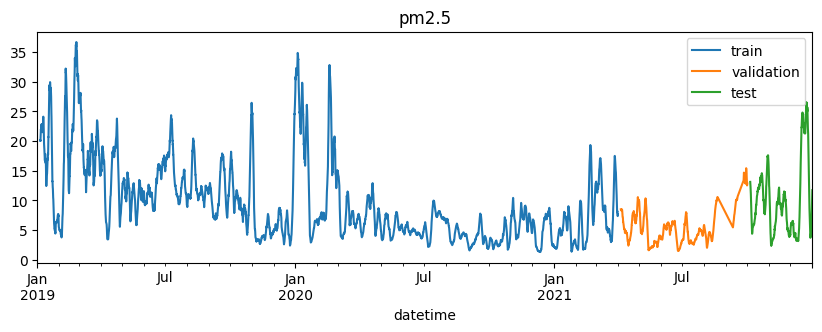

In [16]:
# Plotting one feature
# ==============================================================================
set_dark_theme()
fig, ax = plt.subplots(figsize=(10, 3))
air_quality_train["pm2.5"].rolling(100).mean().plot(ax=ax, label="train")
air_quality_val["pm2.5"].rolling(100).mean().plot(ax=ax, label="validation")
air_quality_test["pm2.5"].rolling(100).mean().plot(ax=ax, label="test")
ax.set_title("pm2.5")
ax.legend();

## Types of problems in time series modeling

### 1:1 Single-Step Forecasting - Predict one step ahead of a single series using the same series as predictor.


This type of problem involves modeling a time series using only its own past. It is a typical autoregressive problem.

Although tensorflow-keras facilitates the process of creating *deep learning* architectures, it is not always trivial to determine the Xtrain and Ytrain dimensions requiered to run an LSTM model. The dimensions depend on how many time series are being modeled, how many of them are are used as predictors, and the length of the prediction horizon.


<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">&#9998 Note</b>
</p>

The `create_and_compile_model` function is designed to facilitate the creation of the Tensorflow model. Advanced users can create their own architectures and pass them to the skforecast RNN Forecaster. Input and output dimensions must match the use case to which the model will be applied. the Annex at the end of the document for more details.

</div>

In [17]:
# Create model
# ==============================================================================
series = ["o3"] # Series used as predictors
levels = ["o3"] # Target serie to predict
lags = 32 # Past time steps to be used to predict the target
steps = 1 # Future time steps to be predicted

data = air_quality[series].copy()
data_train = air_quality_train[series].copy()
data_val = air_quality_val[series].copy()
data_test = air_quality_test[series].copy()

model = create_and_compile_model(
    series=data_train,
    levels=levels, 
    lags=lags,
    steps=steps,
    recurrent_layer="LSTM",
    recurrent_units=4,
    dense_units=16,
    optimizer=Adam(learning_rate=0.01), 
    loss=MeanSquaredError()
)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 1)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 4)                 96        
                                                                 
 dense_2 (Dense)             (None, 16)                80        
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
 reshape_1 (Reshape)         (None, 1, 1)              0         
                                                                 
Total params: 193 (772.00 Byte)
Trainable params: 193 (772.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
# Forecaster Definition
# ==============================================================================
forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    transformer_series=MinMaxScaler(),
    fit_kwargs={
        "epochs": 10,  # Number of epochs to train the model.
        "batch_size": 32,  # Batch size to train the model.
        "callbacks": [
            EarlyStopping(monitor="val_loss", patience=5)
        ],  # Callback to stop training when it is no longer learning.
        "series_val": data_val,  # Validation data for model training.
    },
)    

forecaster

/home/ubuntu/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:225: UserWarning: Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.
  warnings.warn(
/home/ubuntu/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:252: UserWarning: `steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.
  warnings.warn(


ForecasterRnn 
Regressor: <keras.src.engine.functional.Functional object at 0x7629ced21a10> 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32] 
Transformer for series: MinMaxScaler() 
Window size: 32 
Target series, levels: ['o3'] 
Multivariate series (names): None 
Maximum steps predicted: [1] 
Training range: None 
Training index type: None 
Training index frequency: None 
Model parameters: {'name': 'model_1', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 32, 1), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_2'}, 'registered_name': None, 'name': 'input_2', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'lstm_1', 'trainable': True, 'dtype': 'float32', 'return_sequences': False, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 'time_major': False, 'units': 4

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff1744;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>


The output warning indicates that the number of lags has been inferred from the model architecture. In this case, the model has an LSTM layer with 32 neurons, so the number of lags is 32. If a different number of lags is desired, the `lags` argument can be specified in the `create_and_compile_model` function.
To omit the warning, set `lags=lags` and `steps=steps` arguments can be specified in the initialization of the `ForecasterRnn`.

</div>

In [19]:
# Fit forecaster
# ==============================================================================
forecaster.fit(data_train)

Epoch 1/10
615/615 [==============================] - 8s 11ms/step - loss: 0.0116 - val_loss: 0.0061
Epoch 2/10
615/615 [==============================] - 6s 10ms/step - loss: 0.0056 - val_loss: 0.0059
Epoch 3/10
615/615 [==============================] - 6s 10ms/step - loss: 0.0056 - val_loss: 0.0059
Epoch 4/10
615/615 [==============================] - 6s 10ms/step - loss: 0.0056 - val_loss: 0.0061
Epoch 5/10
615/615 [==============================] - 6s 10ms/step - loss: 0.0055 - val_loss: 0.0058
Epoch 6/10
615/615 [==============================] - 6s 10ms/step - loss: 0.0055 - val_loss: 0.0057
Epoch 7/10
615/615 [==============================] - 6s 10ms/step - loss: 0.0056 - val_loss: 0.0062
Epoch 8/10
615/615 [==============================] - 6s 10ms/step - loss: 0.0054 - val_loss: 0.0059
Epoch 9/10
615/615 [==============================] - 6s 10ms/step - loss: 0.0054 - val_loss: 0.0057
Epoch 10/10
615/615 [==============================] - 6s 10ms/step - loss: 0.0054 - val_lo

Overfitting can be tracked by moniting the loss function on the validation set. Metrics are automatically stored in the `history` attribute of the `ForecasterRnn` object. The method `plot_history` can be used to visualize the training and validation loss.

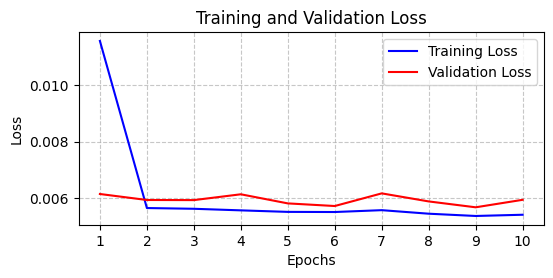

In [20]:
# Track training and overfitting
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
forecaster.plot_history(ax=ax)

In [21]:
# Predictions
# ==============================================================================
predictions = forecaster.predict()
predictions

,o3
2021-04-01,45.585812


In [22]:
# Backtesting with test data
# ==============================================================================
metrics, predictions = backtesting_forecaster_multiseries(
    forecaster=forecaster,
    steps=forecaster.max_step,
    series=data,
    levels=forecaster.levels,
    initial_train_size=len(data.loc[:end_validation, :]), # Training + Validation Data
    metric="mean_absolute_error",
    verbose=True,
    refit=False,
)

Epoch 1/10
752/752 [==============================] - 6s 7ms/step - loss: 0.0055 - val_loss: 0.0057
Epoch 2/10
752/752 [==============================] - 5s 7ms/step - loss: 0.0055 - val_loss: 0.0056
Epoch 3/10
752/752 [==============================] - 5s 7ms/step - loss: 0.0054 - val_loss: 0.0056
Epoch 4/10
752/752 [==============================] - 5s 7ms/step - loss: 0.0055 - val_loss: 0.0068
Epoch 5/10
752/752 [==============================] - 5s 7ms/step - loss: 0.0054 - val_loss: 0.0055
Epoch 6/10
752/752 [==============================] - 5s 7ms/step - loss: 0.0054 - val_loss: 0.0062
Epoch 7/10
752/752 [==============================] - 5s 7ms/step - loss: 0.0054 - val_loss: 0.0055
Epoch 8/10
752/752 [==============================] - 5s 7ms/step - loss: 0.0054 - val_loss: 0.0060
Epoch 9/10
752/752 [==============================] - 5s 7ms/step - loss: 0.0054 - val_loss: 0.0055
Epoch 10/10
752/752 [==============================] - 5s 7ms/step - loss: 0.0054 - val_loss: 0.0055

100%|██████████| 2208/2208 [02:47<00:00, 13.21it/s]


In [23]:
# Backtesting predictions
# ==============================================================================
predictions

,o3
2021-10-01 00:00:00,55.291424
2021-10-01 01:00:00,60.048378
2021-10-01 02:00:00,64.030525
2021-10-01 03:00:00,64.016846
2021-10-01 04:00:00,53.900356
...,...
2021-12-31 19:00:00,17.172762
2021-12-31 20:00:00,16.771116
2021-12-31 21:00:00,17.334808
2021-12-31 22:00:00,17.117558


In [24]:
# % Error vs series mean
# ==============================================================================
rel_mse = 100 * metrics.loc[0, 'mean_absolute_error'] / np.mean(data["o3"])
print(f"Serie mean: {np.mean(data['o3']):0.2f}")
print(f"Relative error (mae): {rel_mse:0.2f} %")

Serie mean: 54.52
Relative error (mae): 10.95 %


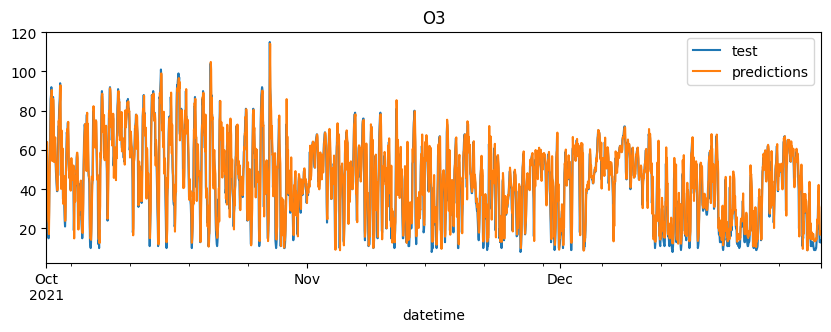

In [25]:
# Plotting predictions vs real values in the test set
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 3))
data_test["o3"].plot(ax=ax, label="test")
predictions["o3"].plot(ax=ax, label="predictions")
ax.set_title("O3")
ax.legend();

### 1:1 Multiple-Step Forecasting - Predict a single series using the same series as predictor. Multiple steps ahead.



The next case is similar to the previous one, but now the goal is to predict multiple future values. In this scenario multiple future steps of a single time series are modeled using only its past values.

A similar architecture to the previous one will be used, but with a greater number of neurons in the LSTM layer and in the first dense layer. This will allow the model to have greater flexibility to predict the time series.

In [26]:
# Model creation
# ==============================================================================
series = ["o3"] # Series used as predictors
levels = ["o3"] # Target serie to predict
lags = 32 # Past time steps to be used to predict the target
steps = 5 # Future time steps to be predicted


model = create_and_compile_model(
    series=data_train,
    levels=levels, 
    lags=lags,
    steps=steps,
    recurrent_layer="LSTM",
    recurrent_units=50,
    dense_units=32,
    optimizer=Adam(learning_rate=0.01), 
    loss=MeanSquaredError()
)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 1)]           0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                10400     
                                                                 
 dense_4 (Dense)             (None, 32)                1632      
                                                                 
 dense_5 (Dense)             (None, 5)                 165       
                                                                 
 reshape_2 (Reshape)         (None, 5, 1)              0         
                                                                 
Total params: 12197 (47.64 KB)
Trainable params: 12197 (47.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
# Forecaster Creation
# ==============================================================================
forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    transformer_series=MinMaxScaler(),
    fit_kwargs={
        "epochs": 3,  # Number of epochs to train the model.
        "batch_size": 32,  # Batch size to train the model.
        "callbacks": [
            EarlyStopping(monitor="val_loss", patience=5)
        ],  # Callback to stop training when it is no longer learning.
        "series_val": data_val,  # Validation data for model training.
    },
)    

forecaster

/home/ubuntu/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:225: UserWarning: Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.
  warnings.warn(
/home/ubuntu/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:252: UserWarning: `steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.
  warnings.warn(


ForecasterRnn 
Regressor: <keras.src.engine.functional.Functional object at 0x7629b64098d0> 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32] 
Transformer for series: MinMaxScaler() 
Window size: 32 
Target series, levels: ['o3'] 
Multivariate series (names): None 
Maximum steps predicted: [1 2 3 4 5] 
Training range: None 
Training index type: None 
Training index frequency: None 
Model parameters: {'name': 'model_2', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 32, 1), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_3'}, 'registered_name': None, 'name': 'input_3', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'lstm_2', 'trainable': True, 'dtype': 'float32', 'return_sequences': False, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 'time_major': False, 'u

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">&#9998 Note</b>
</p>

The `fit_kwargs` parameter allows the user to set any Tensorflow-based configuration in the model. In the example, 10 training epochs are defined with a batch size of 32. An `EarlyStopping` callback is configured to stop training when the validation loss stops decreasing for 5 epochs (`patience=5`). Other callbacks can also be configured, such as `ModelCheckpoint` to save the model at each epoch, or even Tensorboard to visualize the training and validation loss in real time.

</div>



In [28]:
# Fit forecaster
# ==============================================================================
forecaster.fit(data_train)

Epoch 1/3


615/615 [==============================] - 10s 14ms/step - loss: 0.0190 - val_loss: 0.0145
Epoch 2/3
615/615 [==============================] - 8s 14ms/step - loss: 0.0133 - val_loss: 0.0126
Epoch 3/3
615/615 [==============================] - 8s 14ms/step - loss: 0.0125 - val_loss: 0.0132


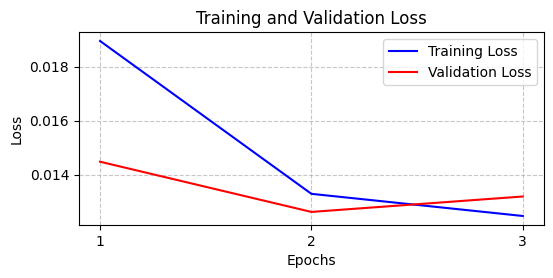

In [29]:
# Train and overfitting tracking
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
forecaster.plot_history(ax=ax)

In [30]:
# Prediction
# ==============================================================================
predictions = forecaster.predict()
predictions

,o3
2021-04-01 00:00:00,46.680180
2021-04-01 01:00:00,42.978771
2021-04-01 02:00:00,38.489998
2021-04-01 03:00:00,33.926380
2021-04-01 04:00:00,32.742973


In [31]:
# Specific step predictions
# ==============================================================================
predictions = forecaster.predict(steps=[1, 3])
predictions

,o3
2021-04-01 00:00:00,46.680180
2021-04-01 02:00:00,38.489998


In [32]:
# Backtesting 
# ==============================================================================
metrics, predictions = backtesting_forecaster_multiseries(
    forecaster=forecaster,
    steps=forecaster.max_step,
    series=data,
    levels=forecaster.levels,
    initial_train_size=len(data.loc[:end_validation, :]),
    metric="mean_absolute_error",
    verbose=False,
    refit=False,
)

Epoch 1/3
752/752 [==============================] - 13s 16ms/step - loss: 0.0118 - val_loss: 0.0122
Epoch 2/3
752/752 [==============================] - 11s 15ms/step - loss: 0.0118 - val_loss: 0.0116
Epoch 3/3
752/752 [==============================] - 11s 14ms/step - loss: 0.0115 - val_loss: 0.0112


100%|██████████| 442/442 [00:33<00:00, 13.08it/s]


In [33]:
# Backtesting predictions
# ==============================================================================
predictions

,o3
2021-10-01 00:00:00,54.546848
2021-10-01 01:00:00,50.351799
2021-10-01 02:00:00,49.854012
2021-10-01 03:00:00,48.982307
2021-10-01 04:00:00,47.549858
...,...
2021-12-31 19:00:00,18.645006
2021-12-31 20:00:00,18.839693
2021-12-31 21:00:00,13.373547
2021-12-31 22:00:00,13.363232


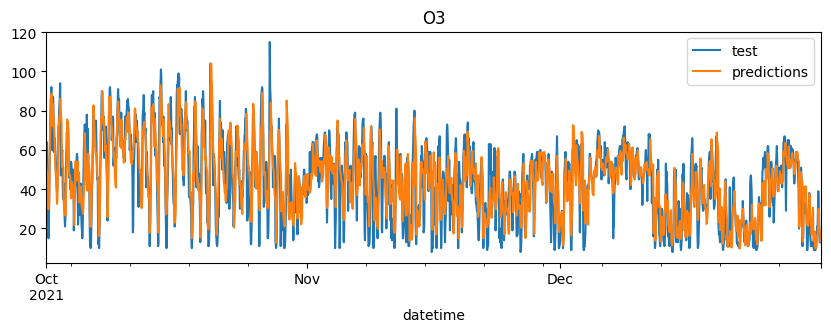

In [34]:
# Plotting predictions vs real values in the test set
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 3))
data_test["o3"].plot(ax=ax, label="test")
predictions["o3"].plot(ax=ax, label="predictions")
ax.set_title("O3")
ax.legend();

In [35]:
# Backtesting metrics
# ==============================================================================
metrics

,levels,mean_absolute_error
0,o3,9.210848


In [36]:
# % Error vs series mean
# ==============================================================================
rel_mse = 100 * metrics.loc[0, 'mean_absolute_error'] / np.mean(data["o3"])
print(f"Serie mean: {np.mean(data['o3']):0.2f}")
print(f"Relative error (mae): {rel_mse:0.2f} %")

Serie mean: 54.52
Relative error (mae): 16.90 %


### N:1 Multiple-Step Forecasting - Predict one series using multiple series as predictors.

In this case, a single series will be predicted, but using multiple time series as predictors. Now, the past values of multiple time series will influence the prediction of a single time series.

In [37]:
# Model creation
# ==============================================================================
# Time series used in the training. Now, it is multiseries
series = ['pm2.5', 'co', 'no', 'no2', 'pm10', 'nox', 'o3', 'veloc.', 'direc.','so2'] 
levels = ["o3"] 
lags = 32 
steps = 5 

data = air_quality[series].copy()
data_train = air_quality_train[series].copy()
data_val = air_quality_val[series].copy()
data_test = air_quality_test[series].copy()

model = create_and_compile_model(
    series=data_train,
    levels=levels, 
    lags=lags,
    steps=steps,
    recurrent_layer="LSTM",
    recurrent_units=[100, 50],
    dense_units=[64, 32],
    optimizer=Adam(learning_rate=0.01), 
    loss=MeanSquaredError()
)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 10)]          0         
                                                                 
 lstm_3 (LSTM)               (None, 32, 100)           44400     
                                                                 
 lstm_4 (LSTM)               (None, 50)                30200     
                                                                 
 dense_6 (Dense)             (None, 64)                3264      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 5)                 165       
                                                                 
 reshape_3 (Reshape)         (None, 5, 1)              0   

In [38]:
# Forecaster creation
# ==============================================================================
forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    steps=steps,
    lags=lags,
    transformer_series=MinMaxScaler(),
    fit_kwargs={
        "epochs": 4,  
        "batch_size": 128,  
        "series_val": data_val,
    },
)
forecaster

ForecasterRnn 
Regressor: <keras.src.engine.functional.Functional object at 0x762992309a10> 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32] 
Transformer for series: MinMaxScaler() 
Window size: 32 
Target series, levels: ['o3'] 
Multivariate series (names): None 
Maximum steps predicted: [1 2 3 4 5] 
Training range: None 
Training index type: None 
Training index frequency: None 
Model parameters: {'name': 'model_3', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 32, 10), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_4'}, 'registered_name': None, 'name': 'input_4', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'lstm_3', 'trainable': True, 'dtype': 'float32', 'return_sequences': True, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 'time_major': False, 'u

In [39]:
# Fit forecaster
# ==============================================================================
forecaster.fit(data_train)

Epoch 1/4


154/154 [==============================] - 14s 75ms/step - loss: 0.0392 - val_loss: 0.0229
Epoch 2/4
154/154 [==============================] - 11s 70ms/step - loss: 0.0151 - val_loss: 0.0176
Epoch 3/4
154/154 [==============================] - 11s 71ms/step - loss: 0.0122 - val_loss: 0.0149
Epoch 4/4
154/154 [==============================] - 10s 67ms/step - loss: 0.0118 - val_loss: 0.0130


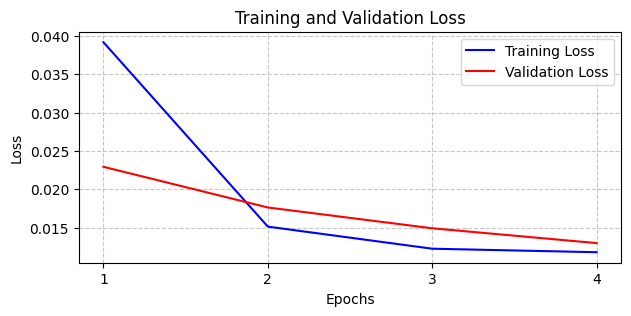

In [40]:
# Trainig and overfitting tracking
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
forecaster.plot_history(ax=ax)

In [41]:
# Prediction
# ==============================================================================
predictions = forecaster.predict()
predictions

,o3
2021-04-01 00:00:00,54.929440
2021-04-01 01:00:00,46.733131
2021-04-01 02:00:00,38.083508
2021-04-01 03:00:00,31.381948
2021-04-01 04:00:00,27.006073


In [42]:
# Backtesting with test data
# ==============================================================================
metrics, predictions = backtesting_forecaster_multiseries(
    forecaster=forecaster,
    steps=forecaster.max_step,
    series=data,
    levels=forecaster.levels,
    initial_train_size=len(data.loc[:end_validation, :]), # Datos de entrenamiento + validación
    metric="mean_absolute_error",
    verbose=False,
    refit=False,
)

Epoch 1/4
188/188 [==============================] - 15s 69ms/step - loss: 0.0108 - val_loss: 0.0119
Epoch 2/4
188/188 [==============================] - 12s 65ms/step - loss: 0.0104 - val_loss: 0.0113
Epoch 3/4
188/188 [==============================] - 13s 67ms/step - loss: 0.0102 - val_loss: 0.0135
Epoch 4/4
188/188 [==============================] - 13s 71ms/step - loss: 0.0099 - val_loss: 0.0113


100%|██████████| 442/442 [00:45<00:00,  9.79it/s]


In [43]:
# Backtesting metrics
# ==============================================================================
metrics

,levels,mean_absolute_error
0,o3,10.477673


In [44]:
# % Error vs series mean
# ==============================================================================
rel_mse = 100 * metrics.loc[0, 'mean_absolute_error'] / np.mean(data["o3"])
print(f"Serie mean: {np.mean(data['o3']):0.2f}")
print(f"Relative error (mae): {rel_mse:0.2f} %")

Serie mean: 54.52
Relative error (mae): 19.22 %


In [45]:
# Backtesting predictions
# ==============================================================================
predictions

,o3
2021-10-01 00:00:00,53.566944
2021-10-01 01:00:00,53.006889
2021-10-01 02:00:00,49.591961
2021-10-01 03:00:00,44.384003
2021-10-01 04:00:00,39.712051
...,...
2021-12-31 19:00:00,53.240726
2021-12-31 20:00:00,51.674049
2021-12-31 21:00:00,8.722719
2021-12-31 22:00:00,11.053076


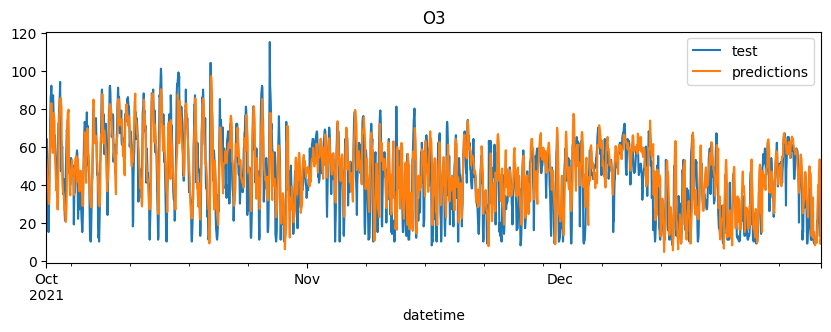

In [46]:
# Plotting predictions vs real values in the test set
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 3))
data_test["o3"].plot(ax=ax, label="test")
predictions["o3"].plot(ax=ax, label="predictions")
ax.set_title("O3")
ax.legend();


### N:M Multiple-Step Forecasting - Multiple time series with multiple outputs

This is a more complex scenario in which multiple time series are predicted using multiple time series as predictors. It is therefore a scenario in which multiple series are modeled simultaneously using a single model. This has special application in many real scenarios, such as the prediction of stock values for several companies based on the stock history, the price of energy and commodities. Or the case of forecasting multiple products in an online store, based on the sales of other products, the price of the products, etc.

In [68]:
# Model creation
# ==============================================================================
# Now, we have multiple series and multiple targets
series = ['pm2.5', 'co', 'no', 'no2', 'pm10', 'nox', 'o3', 'veloc.', 'direc.','so2'] 
levels = ['pm2.5', 'co', 'no', "o3"] #  Features to predict. It can be all the series or less
lags = 32 
steps = 5 

data = air_quality[series].copy()
data_train = air_quality_train[series].copy()
data_val = air_quality_val[series].copy()
data_test = air_quality_test[series].copy()

model = create_and_compile_model(
    series=data_train,
    levels=levels, 
    lags=lags,
    steps=steps,
    recurrent_layer="LSTM",
    recurrent_units=[100, 50],
    dense_units=[64, 32],
    optimizer=Adam(learning_rate=0.01), 
    loss=MeanSquaredError()
)
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 10)]          0         
                                                                 
 lstm_7 (LSTM)               (None, 32, 100)           44400     
                                                                 
 lstm_8 (LSTM)               (None, 50)                30200     
                                                                 
 dense_12 (Dense)            (None, 64)                3264      
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 20)                660       
                                                                 
 reshape_5 (Reshape)         (None, 5, 4)              0   

In [69]:
# Forecaster creation
# ==============================================================================
forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    steps=steps,
    lags=lags,
    transformer_series=MinMaxScaler(),
    fit_kwargs={
        "epochs": 10, 
        "batch_size": 128, 
        "callbacks": [
            EarlyStopping(monitor="val_loss", patience=3)
        ],  
        "series_val": data_val,
    },
)
forecaster

ForecasterRnn 
Regressor: <keras.src.engine.functional.Functional object at 0x7629b62f33d0> 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32] 
Transformer for series: MinMaxScaler() 
Window size: 32 
Target series, levels: ['pm2.5', 'co', 'no', 'o3'] 
Multivariate series (names): None 
Maximum steps predicted: [1 2 3 4 5] 
Training range: None 
Training index type: None 
Training index frequency: None 
Model parameters: {'name': 'model_5', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 32, 10), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_6'}, 'registered_name': None, 'name': 'input_6', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'lstm_7', 'trainable': True, 'dtype': 'float32', 'return_sequences': True, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 't

The prediction can also be made for specific `steps`, as long as they are within the prediction horizon defined in the model.

In [52]:
# Specific step predictions
# ==============================================================================
forecaster.predict(steps=[1, 5], levels="o3")

,o3
2021-04-01 00:00:00,-44.007244
2021-04-01 04:00:00,-49.890579


In [70]:
# Backtesting with test data
# ==============================================================================
metrics, predictions = backtesting_forecaster_multiseries(
    forecaster=forecaster,
    steps=forecaster.max_step,
    series=data,
    levels=forecaster.levels,
    initial_train_size=len(data.loc[:end_validation, :]),
    metric="mean_absolute_error",
    verbose=False,
    refit=False,
)

absl       WARNING Skipping variable loading for optimizer 'Adam', because it has 25 variables whereas the saved optimizer has 1 variables. 


  5%|▌         | 115/2208 [36:18<11:00:42, 18.94s/it]


Epoch 1/10
188/188 [==============================] - 15s 69ms/step - loss: 0.0097 - val_loss: 0.0110
Epoch 2/10
188/188 [==============================] - 12s 66ms/step - loss: 0.0050 - val_loss: 0.0089
Epoch 3/10
188/188 [==============================] - 12s 66ms/step - loss: 0.0045 - val_loss: 0.0092
Epoch 4/10
188/188 [==============================] - 12s 66ms/step - loss: 0.0042 - val_loss: 0.0088
Epoch 5/10
188/188 [==============================] - 12s 65ms/step - loss: 0.0040 - val_loss: 0.0083
Epoch 6/10
188/188 [==============================] - 12s 65ms/step - loss: 0.0038 - val_loss: 0.0071
Epoch 7/10
188/188 [==============================] - 12s 65ms/step - loss: 0.0036 - val_loss: 0.0066
Epoch 8/10
188/188 [==============================] - 12s 65ms/step - loss: 0.0035 - val_loss: 0.0067
Epoch 9/10
188/188 [==============================] - 12s 65ms/step - loss: 0.0035 - val_loss: 0.0072
Epoch 10/10
188/188 [==============================] - 12s 65ms/step - loss: 0.003

100%|██████████| 442/442 [00:44<00:00, 10.03it/s]


In [ ]:
# Prediction
# ==============================================================================
predictions = forecaster.predict()
predictions

,pm2.5,co,no,o3
2021-04-01 00:00:00,-25.901281,0.192014,8.124165,-44.007244
2021-04-01 01:00:00,14.341092,0.310921,12.542960,5.296922
2021-04-01 02:00:00,-1.960247,0.268373,-47.631680,-39.819172
2021-04-01 03:00:00,14.030065,0.030274,3.056263,-63.149120
2021-04-01 04:00:00,8.696919,0.159938,21.218948,-49.890579


In [71]:
# Backtesting metrics
# ==============================================================================
metrics

,levels,mean_absolute_error
0,pm2.5,3.667387
1,co,0.030108
2,no,2.982873
3,o3,11.020999


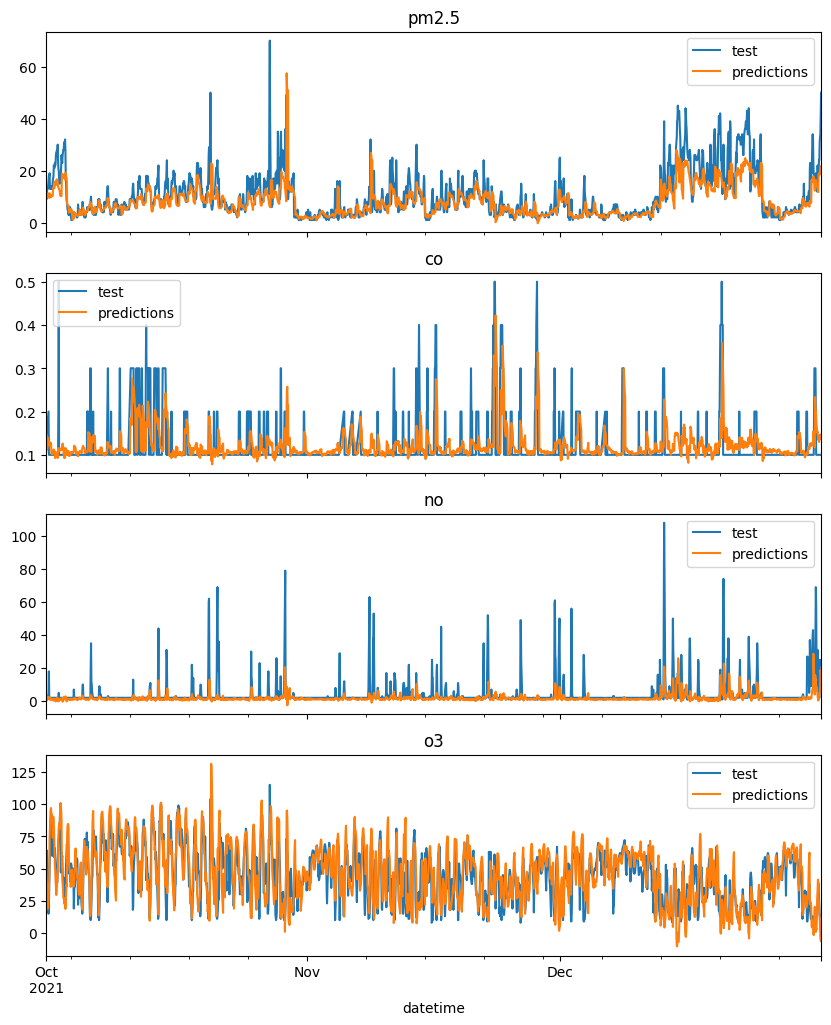

In [72]:
# plot all the predicted variables as rows in the plot
# ==============================================================================

fig, ax = plt.subplots(len(levels), 1, figsize=(10, 3*len(levels)), sharex=True)
for i, level in enumerate(levels):
    data_test[level].plot(ax=ax[i], label="test")
    predictions[level].plot(ax=ax[i], label="predictions")
    ax[i].set_title(level)
    ax[i].legend()

## Create and compile Tensorflow models

To improve the user experience and speed up the prototyping, development, and production process, skforecast has the `create_and_compile_model` function, with which, by indicating just a few arguments, the architecture is inferred and the model is created.

+ `series`: Time series to be used to train the model

+ `levels`: Time series to be predicted.
  
+ `lags`: Number of time steps to be used to predict the next value.

+ `steps`: Number of time steps to be predicted.

+ `recurrent_layer`: Type of recurrent layer to use. By default, an LSTM layer is used.
  
+ `recurrent_units`: Number of units in the recurrent layer. By default, 100 is used. If a list is passed, a recurrent layer will be created for each element in the list.

+ `dense_units`: Number of units in the dense layer. By default, 64 is used. If a list is passed, a dense layer will be created for each element in the list.
  
+ `optimizer`: Optimizer to use. By default, Adam with a learning rate of 0.01 is used.
  
+ `loss`: Loss function to use. By default, Mean Squared Error is used.


<script src="https://kit.fontawesome.com/d20edc211b.js" crossorigin="anonymous"></script>

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px;
border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px;">
<p class="title">
    <i class="fa-light fa-pencil fa" style="font-size: 18px; color:#00b8d4;"></i>
    <b> &nbsp Note</b>
</p>

The following examples use <code>recurrent_layer="LSTM"</code> but it is also possible to use <code>"RNN"</code> layers.

</div>

In [75]:
# Create model
# ==============================================================================
series = ["o3"] # Series used as predictors
levels = ["o3"] # Target series to predict
lags = 32 # Past time steps to be used to predict the target
steps = 1 # Future time steps to be predicted

data = air_quality[series].copy()
data_train = air_quality_train[series].copy()
data_val = air_quality_val[series].copy()
data_test = air_quality_test[series].copy()

model = create_and_compile_model(
    series=data_train,
    levels=levels, 
    lags=lags,
    steps=steps,
    recurrent_layer="LSTM",
    recurrent_units=4,
    dense_units=16,
    optimizer=Adam(learning_rate=0.01), 
    loss=MeanSquaredError()
)
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 32, 1)]           0         
                                                                 
 lstm_11 (LSTM)              (None, 4)                 96        
                                                                 
 dense_18 (Dense)            (None, 16)                80        
                                                                 
 dense_19 (Dense)            (None, 1)                 17        
                                                                 
 reshape_7 (Reshape)         (None, 1, 1)              0         
                                                                 
Total params: 193 (772.00 Byte)
Trainable params: 193 (772.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In this case, a simple LSTM network is used, with a single recurrent layer with 4 neurons and a hidden dense layer with 16 neurons. The following table shows a detailed description of each layer:


| Layer                        | Type            | Output Shape      | Parameters  | Description                                                                                         |
|-----------------------------|-----------------|-------------------|-------------|-----------------------------------------------------------------------------------------------------|
| Input Layer (InputLayer)    | `InputLayer`    | `(None, 32, 1)`   | 0           | This is the input layer of the model. It receives sequences of length 32, corresponding to the number of lags with a dimension at each time step. |
| LSTM Layer (Long Short-Term Memory)| `LSTM`       | `(None, 4)`       | 96          | The LSTM layer is a long and short-term memory layer that processes the input sequence. It has 4 LSTM units and connects to the next layer.  |
| First Dense Layer (Dense)   | `Dense`         | `(None, 16)`      | 80          | This is a fully connected layer with 16 units and uses a default activation function (relu) in the provided architecture.     |
| Second Dense Layer (Dense)  | `Dense`         | `(None, 1)`       | 17          | Another fully connected dense layer, this time with a single output unit. It also uses a default activation function.          |
| Reshape Layer (Reshape)     | `Reshape`       | `(None, 1, 1)`    | 0           | This layer reshapes the output of the previous dense layer to have a specific shape `(None, 1, 1)`. This layer is not strictly necessary, but is included to make the module generalizable to other multi-output forecasting problems. The dimension of this output layer is `(None, steps_to_predict_future, series_to_predict)`. In this case, `steps=1 and levels="o3"`, so the dimension is `(None, 1, 1)`  |
| Total Parameters and Trainable | -           | -                 | 193         | Total Parameters: 193, Trainable Parameters: 193, Non-Trainable Parameters: 0               |




More complex models can be created including:

* Multiple series to be modeled (levels)
* Multiple series to be used as predictors (series)
* Multiple steps to be predicted (steps)
* Multiple lags to be used as predictors (lags)
* Multiple recurrent layers (recurrent_units)
* Multiple dense layers (dense_units)

In [77]:
# Model creation
# ==============================================================================
# Now, we have multiple series and multiple targets
series = ['pm2.5', 'co', 'no', 'no2', 'pm10', 'nox', 'o3', 'veloc.', 'direc.','so2'] 
levels = ['pm2.5', 'co', 'no', "o3"] #  Features to predict. It can be all the series or less
lags = 32 
steps = 5 

data = air_quality[series].copy()
data_train = air_quality_train[series].copy()
data_val = air_quality_val[series].copy()
data_test = air_quality_test[series].copy()

model = create_and_compile_model(
    series=data_train,
    levels=levels, 
    lags=lags,
    steps=steps,
    recurrent_layer="LSTM",
    recurrent_units=[100, 50],
    dense_units=[64, 32],
    optimizer=Adam(learning_rate=0.01), 
    loss=MeanSquaredError()
)
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 32, 10)]          0         
                                                                 
 lstm_14 (LSTM)              (None, 32, 100)           44400     
                                                                 
 lstm_15 (LSTM)              (None, 50)                30200     
                                                                 
 dense_23 (Dense)            (None, 64)                3264      
                                                                 
 dense_24 (Dense)            (None, 32)                2080      
                                                                 
 dense_25 (Dense)            (None, 20)                660       
                                                                 
 reshape_9 (Reshape)         (None, 5, 4)              0   

## Get training and test matrices

In [78]:
# Model creation
# ==============================================================================
series = ['pm2.5', 'co', 'no', 'no2', 'pm10', 'nox', 'o3', 'veloc.', 'direc.','so2'] 
levels = ['pm2.5', 'co', 'no', "o3"] #  Features to predict. It can be all the series or less
lags = 32 
steps = 5 

data = air_quality[series].copy()
data_train = air_quality_train[series].copy()
data_val = air_quality_val[series].copy()
data_test = air_quality_test[series].copy()

model = create_and_compile_model(
    series=data_train,
    levels=levels, 
    lags=lags,
    steps=steps,
    recurrent_layer="LSTM",
    recurrent_units=[100, 50],
    dense_units=[64, 32],
    optimizer=Adam(learning_rate=0.01), 
    loss=MeanSquaredError()
)

forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    steps=steps,
    lags=lags,
)
forecaster

ForecasterRnn 
Regressor: <keras.src.engine.functional.Functional object at 0x7629ccf2df10> 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32] 
Transformer for series: MinMaxScaler() 
Window size: 32 
Target series, levels: ['pm2.5', 'co', 'no', 'o3'] 
Multivariate series (names): None 
Maximum steps predicted: [1 2 3 4 5] 
Training range: None 
Training index type: None 
Training index frequency: None 
Model parameters: {'name': 'model_10', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 32, 10), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_11'}, 'registered_name': None, 'name': 'input_11', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'lstm_16', 'trainable': True, 'dtype': 'float32', 'return_sequences': True, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False

In [67]:
forecaster.create_train_X_y(data_train)[2]["X_train"][2]

['pm2.5', 'co', 'no', 'no2', 'pm10', 'nox', 'o3', 'veloc.', 'direc.', 'so2']

The RNN Forecaster can also be used to generate the X_train and y_train matrices that will be used to train the model. The `create_train_X_y` method allows the user to obtain the training and test matrices that will be used to train the model. The method return 3 elements: X_train, y_train, and dimension_information. The X_train matrix has dimensions `(n_samples, n_lags, n_series)`, while the y_train matrix has dimensions `(n_samples, n_steps, n_levels)`.



In [91]:
X_train, y_train, dimension_info = forecaster.create_train_X_y(data_train)

In [92]:
X_train.shape, y_train.shape

((19668, 32, 10), (19668, 5, 4))

The dimension_information dictionary contains the information of each dimension value for both X_train and y_train.

In [85]:
dimension_info["X_train"][0]

[Timestamp('2019-01-02 08:00:00'),
 Timestamp('2019-01-02 09:00:00'),
 Timestamp('2019-01-02 10:00:00'),
 Timestamp('2019-01-02 11:00:00'),
 Timestamp('2019-01-02 12:00:00'),
 Timestamp('2019-01-02 13:00:00'),
 Timestamp('2019-01-02 14:00:00'),
 Timestamp('2019-01-02 15:00:00'),
 Timestamp('2019-01-02 16:00:00'),
 Timestamp('2019-01-02 17:00:00'),
 Timestamp('2019-01-02 18:00:00'),
 Timestamp('2019-01-02 19:00:00'),
 Timestamp('2019-01-02 20:00:00'),
 Timestamp('2019-01-02 21:00:00'),
 Timestamp('2019-01-02 22:00:00'),
 Timestamp('2019-01-02 23:00:00'),
 Timestamp('2019-01-03 00:00:00'),
 Timestamp('2019-01-03 01:00:00'),
 Timestamp('2019-01-03 02:00:00'),
 Timestamp('2019-01-03 03:00:00'),
 Timestamp('2019-01-03 04:00:00'),
 Timestamp('2019-01-03 05:00:00'),
 Timestamp('2019-01-03 06:00:00'),
 Timestamp('2019-01-03 07:00:00'),
 Timestamp('2019-01-03 08:00:00'),
 Timestamp('2019-01-03 09:00:00'),
 Timestamp('2019-01-03 10:00:00'),
 Timestamp('2019-01-03 11:00:00'),
 Timestamp('2019-01-

In [86]:
dimension_info["X_train"][1]

['lag_1',
 'lag_2',
 'lag_3',
 'lag_4',
 'lag_5',
 'lag_6',
 'lag_7',
 'lag_8',
 'lag_9',
 'lag_10',
 'lag_11',
 'lag_12',
 'lag_13',
 'lag_14',
 'lag_15',
 'lag_16',
 'lag_17',
 'lag_18',
 'lag_19',
 'lag_20',
 'lag_21',
 'lag_22',
 'lag_23',
 'lag_24',
 'lag_25',
 'lag_26',
 'lag_27',
 'lag_28',
 'lag_29',
 'lag_30',
 'lag_31',
 'lag_32']

In [87]:
dimension_info["X_train"][2]

['pm2.5', 'co', 'no', 'no2', 'pm10', 'nox', 'o3', 'veloc.', 'direc.', 'so2']

In [88]:
dimension_info["y_train"][0]

[Timestamp('2019-01-02 08:00:00'),
 Timestamp('2019-01-02 09:00:00'),
 Timestamp('2019-01-02 10:00:00'),
 Timestamp('2019-01-02 11:00:00'),
 Timestamp('2019-01-02 12:00:00'),
 Timestamp('2019-01-02 13:00:00'),
 Timestamp('2019-01-02 14:00:00'),
 Timestamp('2019-01-02 15:00:00'),
 Timestamp('2019-01-02 16:00:00'),
 Timestamp('2019-01-02 17:00:00'),
 Timestamp('2019-01-02 18:00:00'),
 Timestamp('2019-01-02 19:00:00'),
 Timestamp('2019-01-02 20:00:00'),
 Timestamp('2019-01-02 21:00:00'),
 Timestamp('2019-01-02 22:00:00'),
 Timestamp('2019-01-02 23:00:00'),
 Timestamp('2019-01-03 00:00:00'),
 Timestamp('2019-01-03 01:00:00'),
 Timestamp('2019-01-03 02:00:00'),
 Timestamp('2019-01-03 03:00:00'),
 Timestamp('2019-01-03 04:00:00'),
 Timestamp('2019-01-03 05:00:00'),
 Timestamp('2019-01-03 06:00:00'),
 Timestamp('2019-01-03 07:00:00'),
 Timestamp('2019-01-03 08:00:00'),
 Timestamp('2019-01-03 09:00:00'),
 Timestamp('2019-01-03 10:00:00'),
 Timestamp('2019-01-03 11:00:00'),
 Timestamp('2019-01-

In [89]:
dimension_info["y_train"][1]

['step_1', 'step_2', 'step_3', 'step_4', 'step_5']

In [90]:
dimension_info["y_train"][2]

['pm2.5', 'co', 'no', 'o3']